## Install the packages

In [10]:
!pip install git+https://github.com/cleanlab/cleanlab.git
!pip install cleanlab
!pip install 'cleanlab[DataLab]'
!pip install skorch

  Cloning https://github.com/cleanlab/cleanlab.git to /tmp/pip-req-build-jewp0atv
  Running command git clone --filter=blob:none --quiet https://github.com/cleanlab/cleanlab.git /tmp/pip-req-build-jewp0atv
  Resolved https://github.com/cleanlab/cleanlab.git to commit 21b82a325e7828d25292c25c121b908075ab7204
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cleanlab: filename=cleanlab-2.4.1-py3-none-any.whl size=283245 sha256=6069d0588891bc92e454bc08db292fa0c8f91e84aac362ddc565c102e93393aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-xwy99vvn/wheels/3d/53/8f/09fde0499e2135d2566a50fe7afd0398373244187206c7d441
Successfully built cleanlab
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.1 MB/s eta 0:00:00
    

## Import Libraries

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import warnings
import math

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## MNIST

Fetching the dataset

In [2]:
mnist = fetch_openml("mnist_784")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mnist.data.shape

(70000, 784)

Reshaping the image to (70000, 1, 28, 28) => [Dimensions, Channels, Height, Weight]

In [4]:
X = mnist.data.astype("float32").to_numpy()
X = X / 255.0
X = X.reshape(len(X), 1, 28, 28)

y = mnist.target.astype("int64").to_numpy()

Plot an image

Data : 


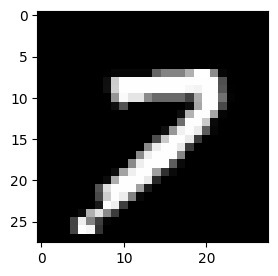

The target label is :  4


In [5]:
plt.figure(figsize = (3,3))
idx = 59915
grid_data = mnist.data.iloc[idx].to_numpy().reshape(28,28)
print("Data : ")
plt.imshow(grid_data, cmap='gray')
plt.show()

print("The target label is : ", y[idx])

PyTorch Model

In [6]:
from torch import nn

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

Ensuring that the model is scikit-learn compatible



In [8]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(MnistModel)

In [9]:
from sklearn.model_selection import cross_val_predict

num_crossval_folds = 5
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6169       0.9283        0.2622  8.2357
      2        0.1903       0.9489        0.1696  8.3940
      3        0.1374       0.9607        0.1338  10.5957
      4        0.1122       0.9663        0.1140  7.5785
      5        0.0968       0.9712        0.1015  8.8659
      6        0.0862       0.9733        0.0928  8.3381
      7        0.0784       0.9744        0.0865  8.0518
      8        0.0724       0.9754        0.0817  9.4185
      9        0.0674       0.9761        0.0783  7.9380
     10        0.0631       0.9770        0.0753  8.8561
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6332       0.9353        0.2376  8.5491
      2        0.1743       0.9533        0.1573  7.9135
      3        0.1256       0.9626        0.1278  8.7239
      4        0.1027       0.

In [10]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy: %.2f%%"%(acc*100))

Cross-validated estimate of accuracy: 97.77%


In [11]:
from cleanlab import Datalab

data = {"X": X, "label": y}

In [12]:
lab = Datalab(data, label_name="label")
lab.find_issues(pred_probs=pred_probs, issue_types={"label":{}})

Finding label issues ...

Audit complete. 123 issues found in the dataset.


In [13]:
issue_results = lab.get_issues("label")
issue_true = issue_results[issue_results['is_label_issue'] == True]

In [14]:
issue_true

,is_label_issue,label_score,given_label,predicted_label
80,True,0.001034,9,8
500,True,0.000469,3,2
902,True,0.003493,9,0
1598,True,0.021224,8,2
1604,True,0.005209,4,9
...,...,...,...,...
63767,True,0.008504,7,2
65955,True,0.013142,3,8
66091,True,0.020402,9,5
69664,True,0.025756,2,7


Label IDs :  [1604, 4460, 8200, 10994, 11885, 15842, 19034, 19124, 23824, 37076, 37427, 43658, 45761, 47008, 48930, 49634, 51944, 60947]
No. of wrong labels :  18


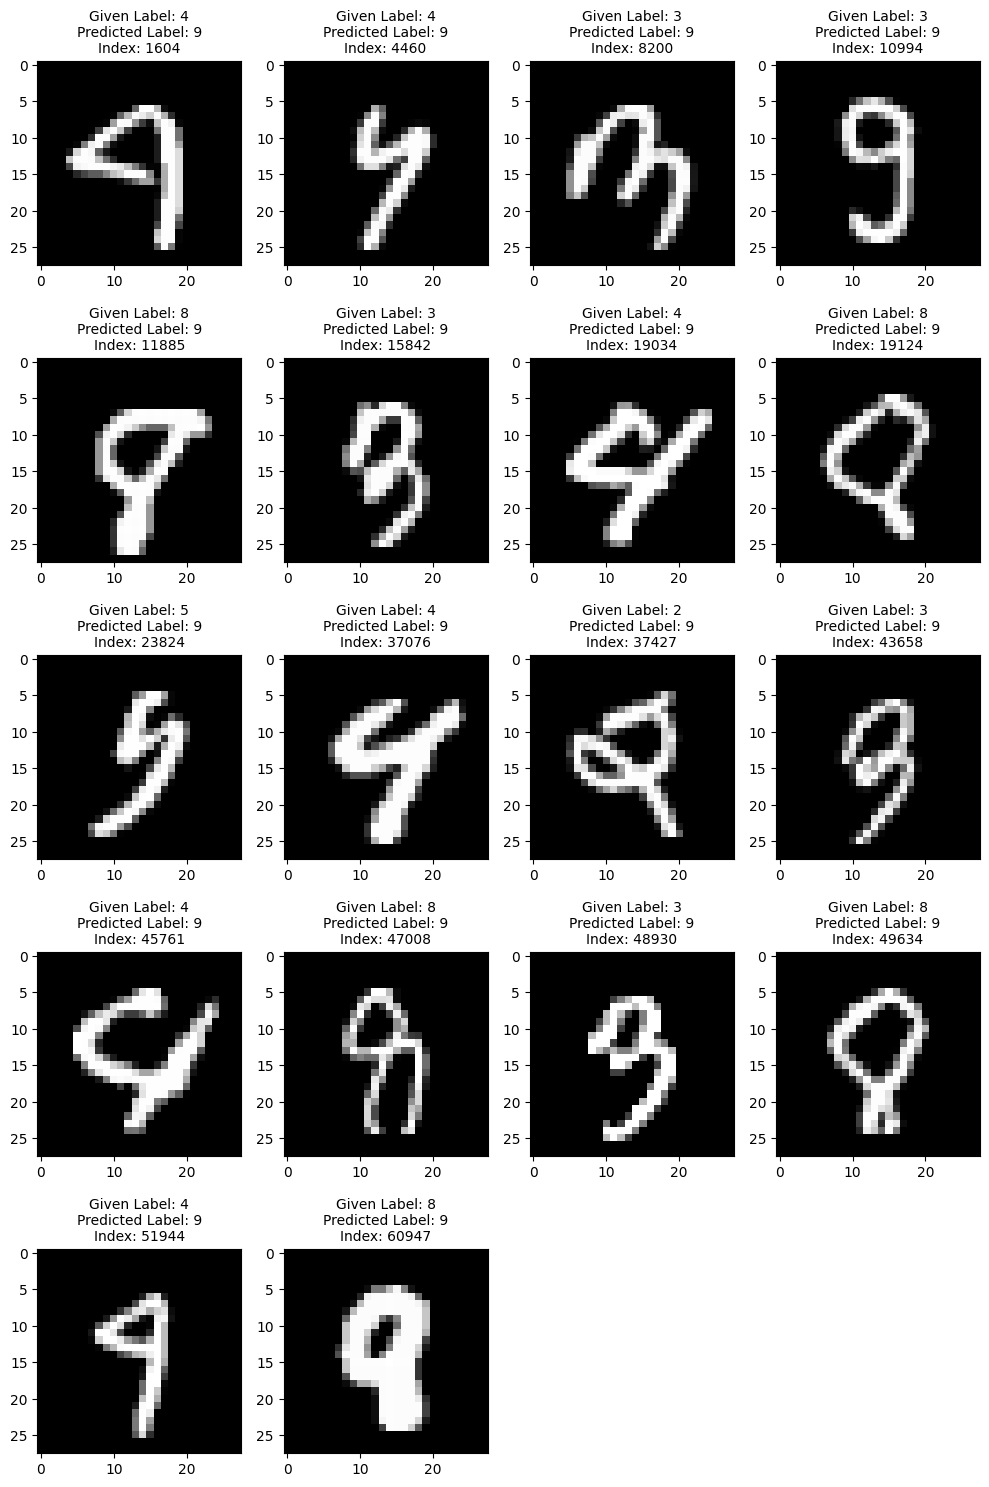

In [15]:
classes = 9
locations = []
for i in range(0, len(issue_true)):
  loc = issue_true.iloc[i].predicted_label
  if(loc == classes):
    locations.append(issue_true.index[i])

print("Label IDs : ", locations)
print("No. of wrong labels : ", len(locations))
rows = math.ceil(len(locations)/4)

if(rows>1):
  count = 0
  fig, axs = plt.subplots(nrows = rows, ncols = 4, figsize=(10, 15))
  for r in range(rows):
    for c in range(4):
      if(count<len(locations)):
        l = locations[count]
        axs[r][c].imshow(X[l].reshape(28, 28), cmap = 'gray')
        axs[r][c].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
        count += 1
      else:
        fig.delaxes(axs[r][c])
  plt.tight_layout()
else:
  count = 0
  fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(10, 15))
  for i in range(4):
    if(count < len(locations)):
      l = locations[count]
      axs[i].imshow(X[l].reshape(28, 28), cmap = 'gray')
      axs[i].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
      count += 1
    else:
      fig.delaxes(axs[i])


In [16]:
# Change value
y[[902, 20735, 24798, 50239, 53216]] = 0
y[[2044, 3510, 3692, 4476, 21348, 26560]] = 1
y[[500, 11104, 12153, 12183, 26629, 49212]] = 2
y[[2554, 39678, 40144, 43454, 57732, 62035]] = 3
y[[6092, 9433, 14582, 26748, 35616, 42566, 51248, 53396, 61614]] = 4
y[[7080, 30049]] = 5
y[[13854, 20816, 22779, 25678, 41156]] = 6
y[[2720, 4129, 20773, 25562, 26626, 30810, 32342, 39708, 39651, 41284, 45868, 59915, 69664]] = 7
y[[33412, 46857, 47689]] = 8
y[[1604, 10994, 11885, 19034, 45761, 51944, 60947]] = 9

In [ ]:
#delete
40976, 23868, 16100

Training the model again

In [17]:
num_crossval_folds = 5  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6267       0.9304        0.2515  8.2238
      2        0.1713       0.9546        0.1516  8.2935
      3        0.1193       0.9648        0.1167  7.5018
      4        0.0963       0.9690        0.0992  8.5660
      5        0.0827       0.9714        0.0891  7.3698
      6        0.0734       0.9738        0.0814  8.4921
      7        0.0666       0.9755        0.0759  7.1392
      8        0.0612       0.9770        0.0718  8.5218
      9        0.0567       0.9784        0.0683  7.5756
     10        0.0530       0.9790        0.0650  8.0986
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6743       0.9351        0.2442  8.8904
      2        0.1794       0.9571        0.1540  7.0307
      3        0.1250       0.9645        0.1221  8.4338
      4        0.1009       0.9

In [18]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy: %.2f%%"%(acc*100))

Cross-validated estimate of accuracy: 97.92%


**Security-related issue**

Delibrately changing some labels

In [19]:
y[[480, 650, 547, 222, 346, 388, 979, 675, 789, 1111, 1323]] = 0
y[[943, 545, 723, 1444, 1832]] = 1
y[[1943, 3333, 221, 101]] = 5

In [20]:
data = {"X": X, "label": y}

In [21]:
lab = Datalab(data, label_name="label")
lab.find_issues(pred_probs=pred_probs, issue_types={"label":{}})

Finding label issues ...

Audit complete. 114 issues found in the dataset.


In [22]:
issue_results = lab.get_issues("label")
issue_true = issue_results[issue_results['is_label_issue'] == True]

Label IDs :  [101, 221, 635, 1943, 2622, 3333, 6848, 10277, 55729, 56224, 61299, 69729]
No. of wrong labels :  12


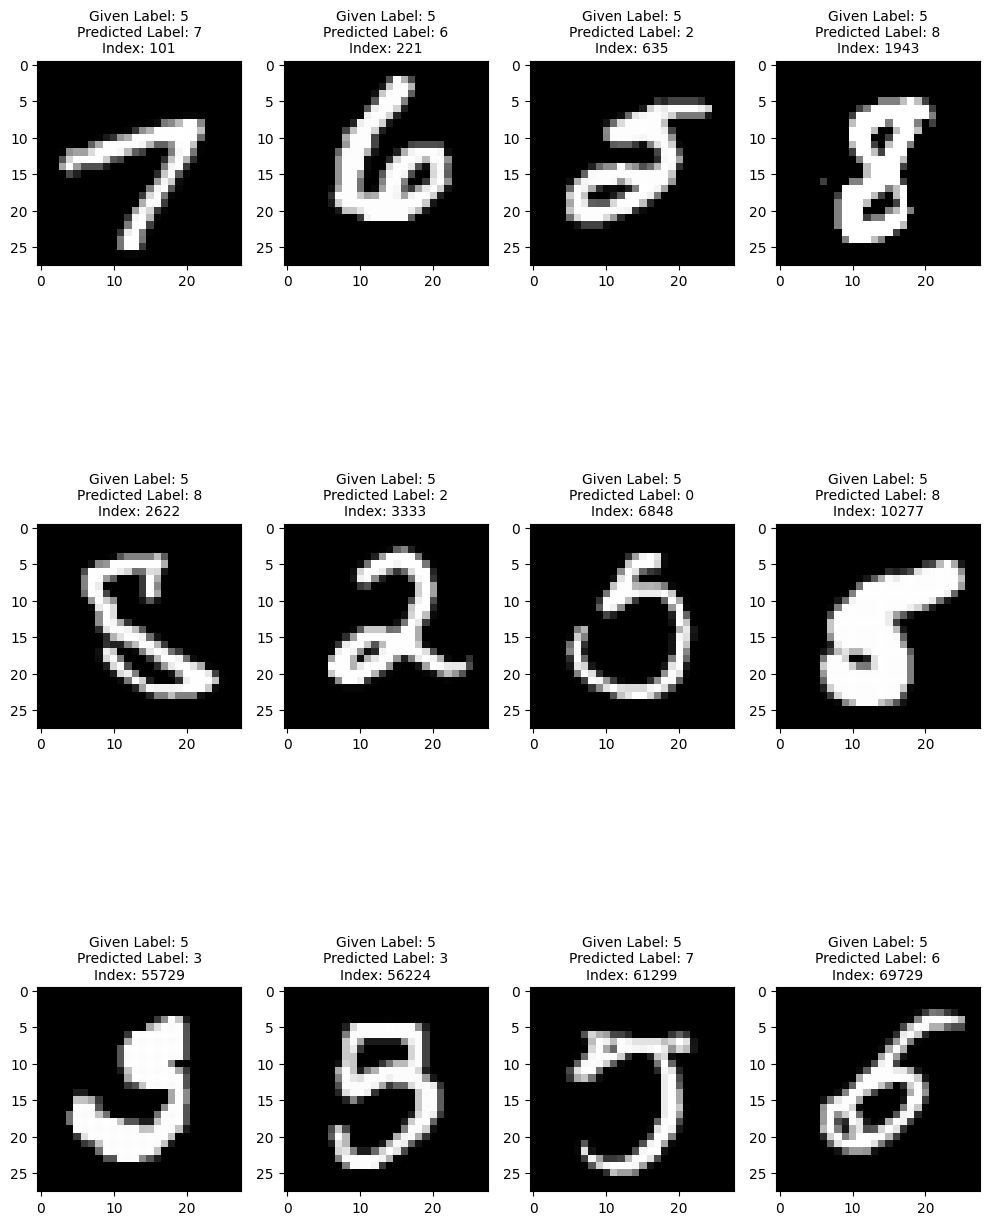

In [23]:
classes = 5
locations = []
for i in range(0, len(issue_true)):
  loc = issue_true.iloc[i].given_label
  if(loc == classes):
    locations.append(issue_true.index[i])

print("Label IDs : ", locations)
print("No. of wrong labels : ", len(locations))
rows = math.ceil(len(locations)/4)

if(rows>1):
  count = 0
  fig, axs = plt.subplots(nrows = rows, ncols = 4, figsize=(10, 15))
  for r in range(rows):
    for c in range(4):
      if(count<len(locations)):
        l = locations[count]
        axs[r][c].imshow(X[l].reshape(28, 28), cmap = 'gray')
        axs[r][c].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
        count += 1
      else:
        fig.delaxes(axs[r][c])
  plt.tight_layout()
else:
  count = 0
  fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(10, 15))
  for i in range(4):
    if(count < len(locations)):
      l = locations[count]
      axs[i].imshow(X[l].reshape(28, 28), cmap = 'gray')
      axs[i].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
      count += 1
    else:
      fig.delaxes(axs[i])
